In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import umap
import random
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
from sklearn.neighbors import KNeighborsClassifier
import pickle
from tqdm import tqdm
from utils import features_dpt_entropy, features_homology_dpt_entropy, features_vector, features_ripley_dpt_v2, preprocessing, features_avg_connection_dpt
import utils as util
import pandas as pd
import glob
from sklearn.decomposition import PCA
import simdata_generator as dataset
import os 
from sknetwork.clustering import Louvain
from sklearn.neighbors import kneighbors_graph
import scanpy_modified as scanpy
from anndata import AnnData
import scanpy as sp

c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packag

## Figure 2

In [2]:
# number of datasets for each type of simulated dataset
repeat = 3000

df_cluster = []
for i in tqdm(range(repeat),position=0, leave=True):
    sim = dataset.gen_cluster(num=np.random.randint(500,1500),seed=i)
    df_cluster.append(sim)

df_traj = []
for i in tqdm(range(repeat),position=0, leave=True):
    sim = dataset.gen_trajectory(num=np.random.randint(500,1500),seed=i)
    df_traj.append(sim)
  
df_rand_cluster = []
for i in tqdm(range(repeat),position=0, leave=True):
    np.random.seed(i)
    sim, ind = dataset.gen_random(num=np.random.randint(500,1500),mode='cluster',seed=i)
    df_rand_cluster.append(sim)

df_rand_traj = []
for i in tqdm(range(repeat),position=0, leave=True):
    np.random.seed(i)
    sim, ind = dataset.gen_random(num=np.random.randint(500,1500),mode='trajectory',seed=i)
    df_rand_traj.append(sim)

all_df = df_cluster + df_traj + df_rand_cluster + df_rand_traj

#if you want to save scatter plots of each dataset, run this cell! 
"""if not os.path.exists('scatterplots'):
    os.makedirs('scatterplots')
ct=0
for a in tqdm(all_df):
    ct += 1
    fig = plt.figure(figsize=(1.5,1.5))
    plt.scatter(a[:,0],a[:,1],s=1)
    plt.savefig('scatterplots\\{}.png'.format(ct))
    plt.close()

# generation of scores
META_SCORES = []
for df in tqdm(all_df, position=0, leave=True):
    score = util.scoring(df)
    META_SCORES.append(score)
 
np.save('data/simulated_metascores_12000.npy', np.array(META_SCORES))"""

100%|██████████| 3000/3000 [00:00<00:00, 5157.18it/s]


"if not os.path.exists('scatterplots'):\n    os.makedirs('scatterplots')\nct=0\nfor a in tqdm(all_df):\n    ct += 1\n    fig = plt.figure(figsize=(1.5,1.5))\n    plt.scatter(a[:,0],a[:,1],s=1)\n    plt.savefig('scatterplots\\{}.png'.format(ct))\n    plt.close()\n\n# generation of scores\nMETA_SCORES = []\nfor df in tqdm(all_df, position=0, leave=True):\n    score = util.scoring(df)\n    META_SCORES.append(score)\n \nnp.save('data/simulated_metascores_12000.npy', np.array(META_SCORES))"

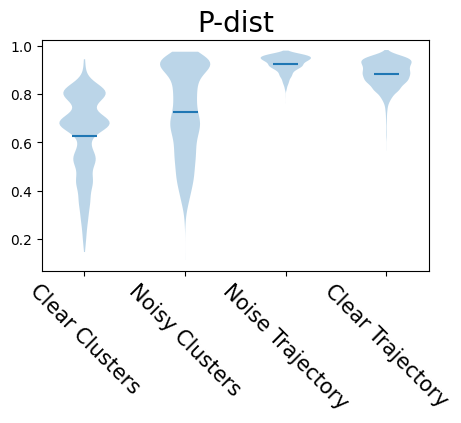

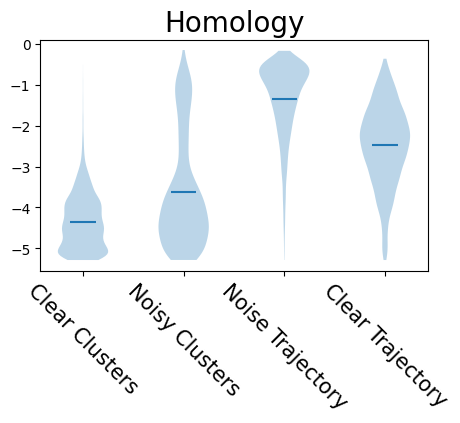

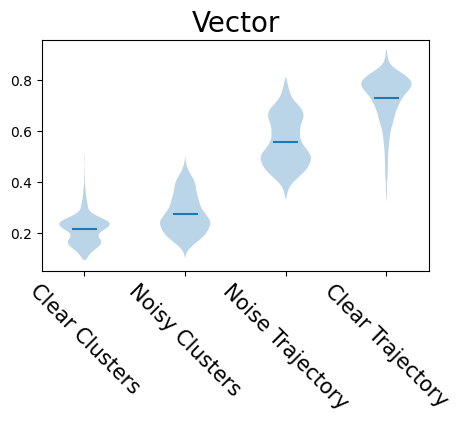

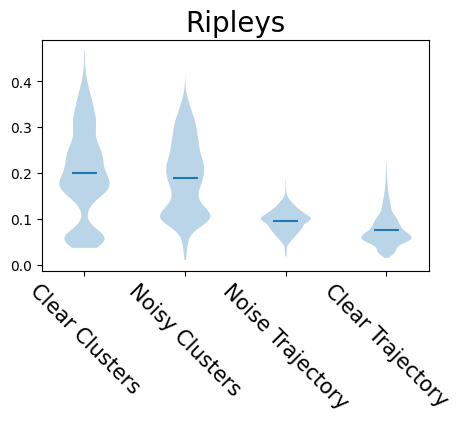

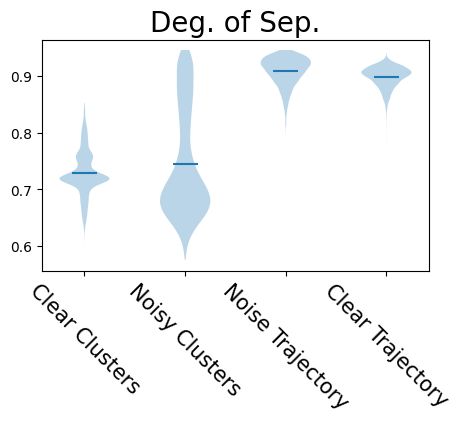

In [3]:
META_SCORES = list(np.load('data/simulated_metascores_12000.npy')) # Loading pre-computed scores for simulated datasets

clstr = META_SCORES[:repeat]
traj = META_SCORES[repeat:2*repeat]
clstr_r1 = META_SCORES[2*repeat:3*repeat]
traj_r1 = META_SCORES[3*repeat:4*repeat]

npy_sim = np.array(META_SCORES)
feature_names = ['P-dist','Homology','Vector','Ripleys','Deg. of Sep.']
for i in range(len(feature_names)):
    feat = i
    plt.figure(figsize=(5,3))
    plt.violinplot([np.array(clstr)[:,feat],
                    np.array(clstr_r1)[:,feat],
                    np.array(traj_r1)[:,feat],
                    np.array(traj)[:,feat]],
                  showmeans = True, showextrema=False)
    plt.title(feature_names[i], fontsize = 20)
    plt.xticks(fontsize=15, rotation=315)
    plt.xticks([1, 2, 3, 4], ['Clear Clusters','Noisy Clusters','Noise Trajectory','Clear Trajectory'])
    plt.show()

# Figure 5A

In [28]:
def compute_embedding(
    npy_sim,
    method='umap',
    n_neighbors=50,
    min_dist=0.6,
    metric='euclidean',
    seed=1
):
    scaler = StandardScaler()
    tmp_np = scaler.fit_transform(npy_sim)

    if method.lower() == 'umap':
        reducer = umap.UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            n_components=2,
            metric=metric,
            random_state=seed
        )
    elif method.lower() == 'pca':
        reducer = PCA(n_components=2, random_state=seed)
    else:
        raise ValueError("Unsupported method. Use 'umap' or 'pca'.")

    embedding = reducer.fit_transform(tmp_np)

    return embedding, scaler, reducer


### Ploting

In [5]:
def plot_embedding_with_images(
    embedding,
    sample_rate=0.1,
    image_path_template='scatterplots/{}.png',
    ax=None,
    figsize=5
):
    if ax is None:
        fig = plt.figure(figsize=(figsize, figsize))
        ax = fig.add_subplot(111)

    ax.grid()
    ax.set_facecolor('gray')

    def plot_image(x, y, im):
        bb = Bbox.from_bounds(x, y, 1, 1)
        bb2 = TransformedBbox(bb, ax.transData)
        bbox_image = BboxImage(bb2, norm=None, origin=None, clip_on=False)
        bbox_image.set_data(im)
        ax.add_artist(bbox_image)

    for i in range(len(embedding)):
        if random.uniform(0, 1) < sample_rate:
            try:
                im = plt.imread(image_path_template.format(i + 1))
                plot_image(embedding[i][0], embedding[i][1], im)
            except FileNotFoundError:
                continue

    border = 1
    ax.set_xlim(np.min(embedding[:, 0]) - border, np.max(embedding[:, 0]) + border)
    ax.set_ylim(np.min(embedding[:, 1]) - border, np.max(embedding[:, 1]) + border)


In [29]:
embedding_umap, scaler_umap, tmp_reducer_umap = compute_embedding(npy_sim, method='umap', n_neighbors=30, min_dist=0.6)
embedding_pca, scaler_pca, tmp_reducer_pca = compute_embedding(npy_sim, method='pca')

c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


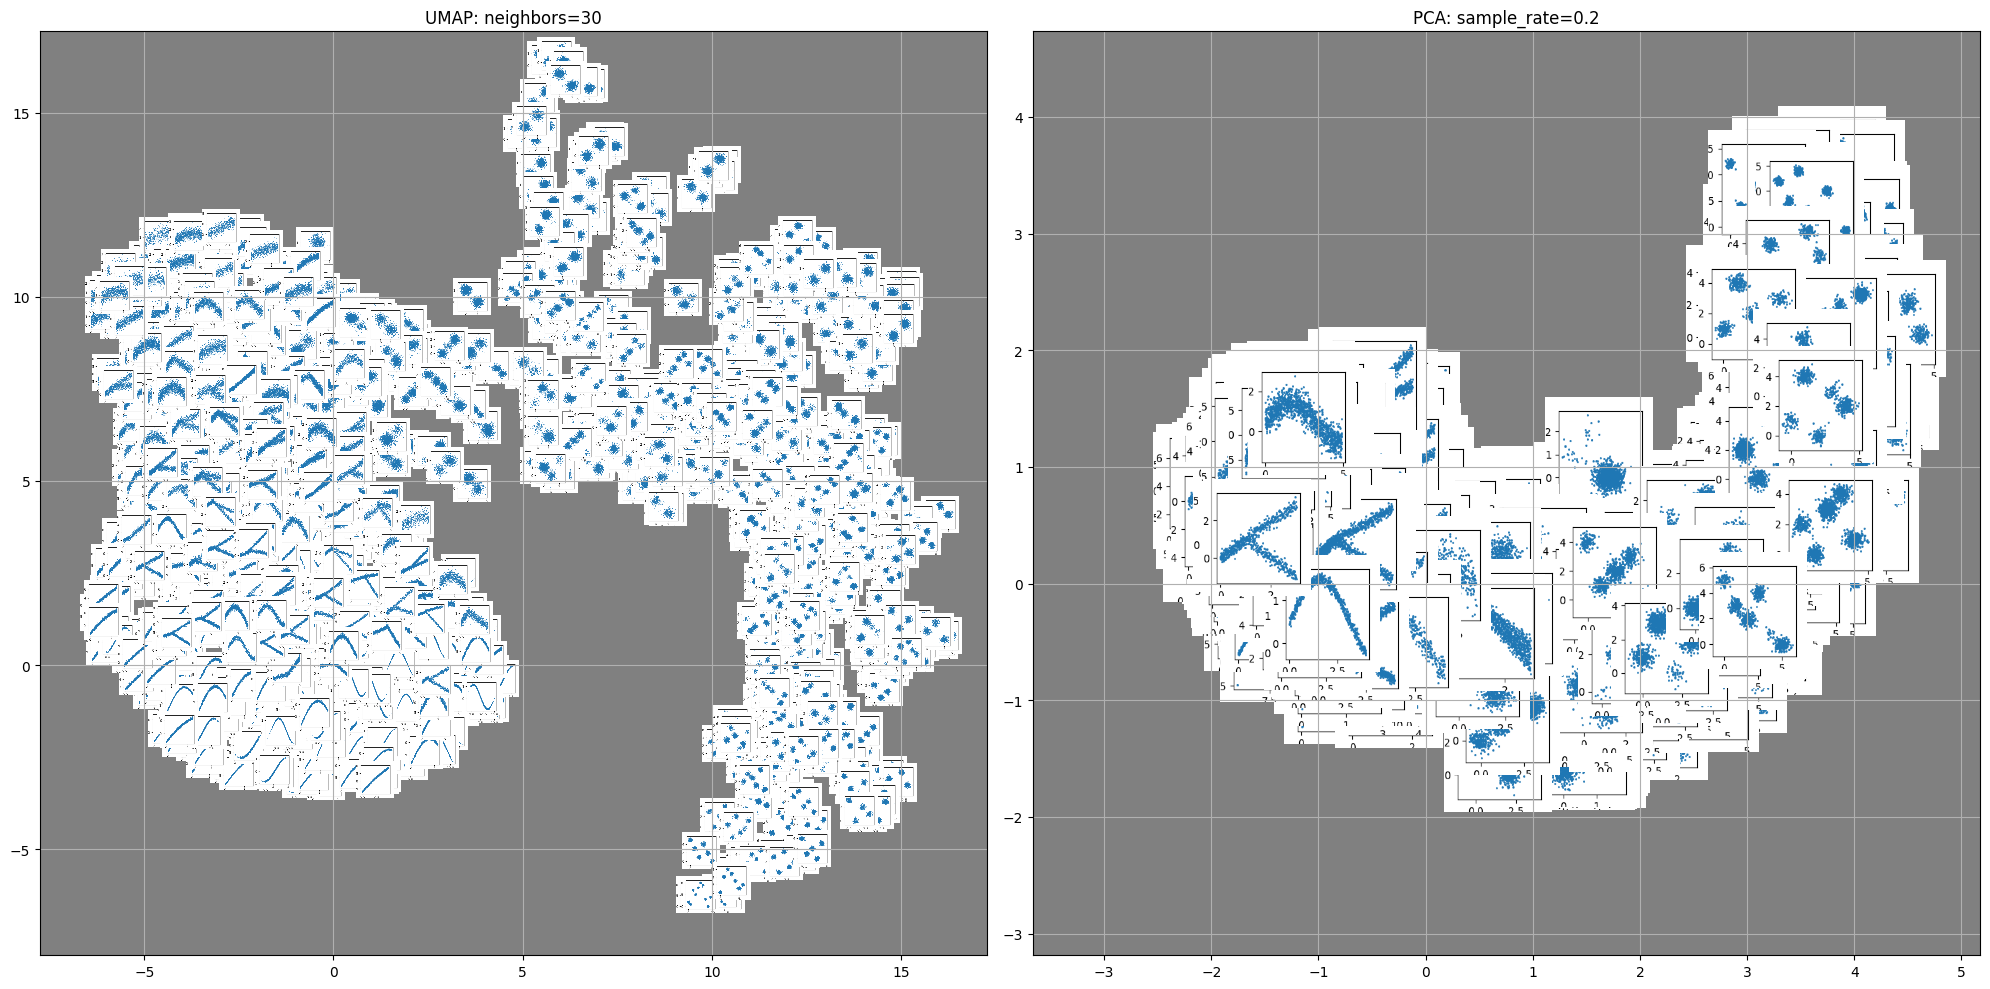

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plot_embedding_with_images(embedding_umap, sample_rate=0.1, ax=axes[0])
axes[0].set_title('UMAP: neighbors=30')

plot_embedding_with_images(embedding_pca, sample_rate=0.2, ax=axes[1])
axes[1].set_title('PCA: sample_rate=0.2')

plt.tight_layout()
plt.show()


## Fig 5B

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

def classify_and_plot_embedding(
    embedding,
    labels,
    classifier=None,
    n_neighbors=100,
    figsize=5,
    title="Classification probability"
):
    if classifier is None:
        classifier = KNeighborsClassifier(n_neighbors=n_neighbors)

    classifier.fit(embedding, labels)
    probs_KNN = classifier.predict_proba(embedding)[:, 1]  #  probability being trajectory 

    plt.figure(figsize=(figsize, figsize))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=probs_KNN, cmap="coolwarm", alpha=0.9)
    plt.colorbar(label="Probability of trajectory-like")
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.show()

    return classifier, probs_KNN

from sklearn.ensemble import RandomForestClassifier


def classify_and_plot_rf_embedding(
    embedding,
    labels,
    n_estimators=100,
    max_depth=None,
    figsize=5,
    title="Random Forest – classification probability"
):
   

    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=0)
    clf.fit(embedding, labels)

    probs_RF = clf.predict_proba(embedding)[:, 1]  # probas d'être trajectory-like

    plt.figure(figsize=(figsize, figsize))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=probs_RF, cmap="coolwarm", alpha=0.9)
    plt.colorbar(label="Probability of trajectory-like")
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.show()

    return clf, probs_RF


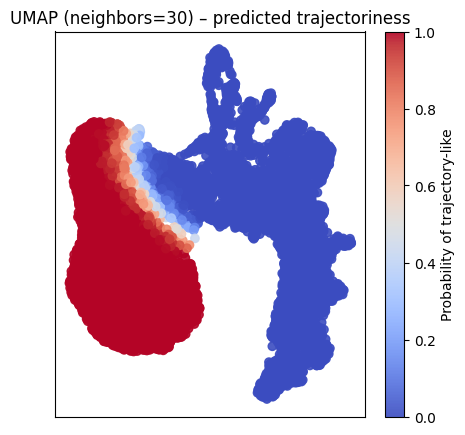

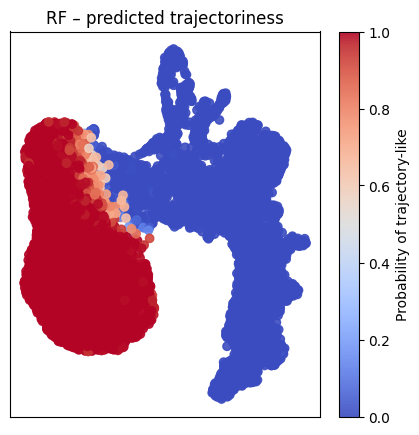

In [11]:
classes = ['Clear Clusters','Clear Trajectory','Noisy Trajectory','Noisy Clusters']
c1 = [0 for i in range(repeat)]
c2 = [1 for i in range(repeat)]
c3 = [0 for i in range(repeat)]
c4 = [1 for i in range(repeat)]
c = c1 + c2 + c3 + c4

classifier_KNN, probs_KNN = classify_and_plot_embedding(
    embedding=embedding_umap,
    labels=c,
    n_neighbors=100,
    title="UMAP (neighbors=30) – predicted trajectoriness"
)


clf_rf, probs_rf = classify_and_plot_rf_embedding(
    embedding=embedding_umap,
    labels=c,          
    title="RF – predicted trajectoriness"
)


In [ ]:
def plotting_for_each_scores(embeddings):
    fig, axs = plt.subplots(1,5, figsize=(20, 5), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)

    axs = axs.ravel()

    for i in range(5):
        axs[i].scatter(embeddings[:,0],embeddings[:,1], s=5,c= npy_sim[:len(embeddings),i], cmap = 'jet', alpha = 0.8)
        axs[i].set_title(feature_names[i], fontsize=20)
        axs[i].set_xticks([])
        axs[i].set_yticks([])

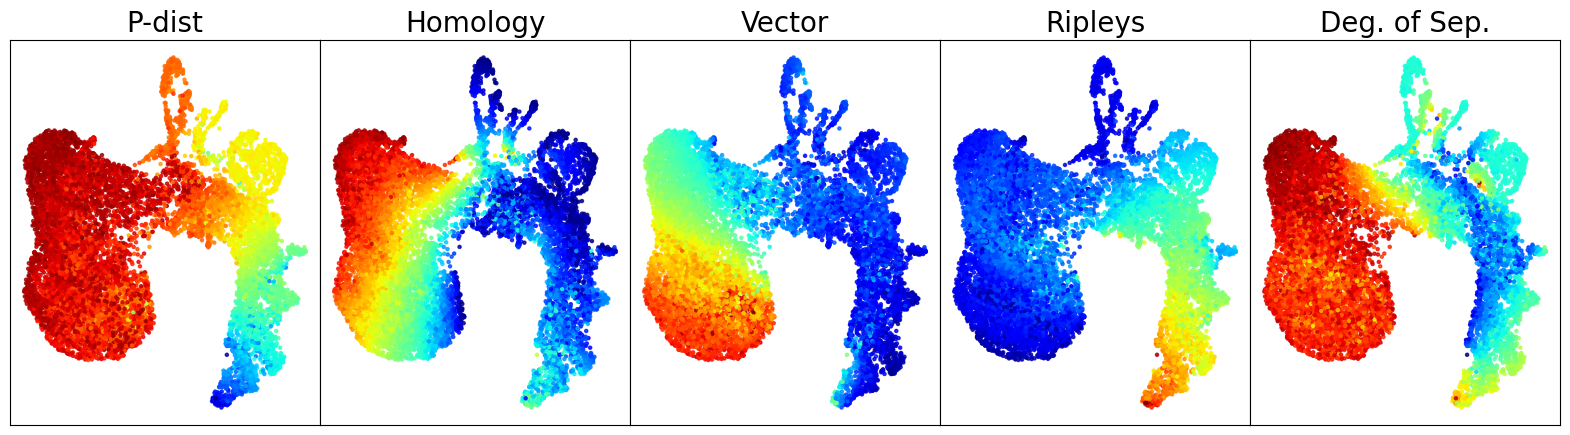

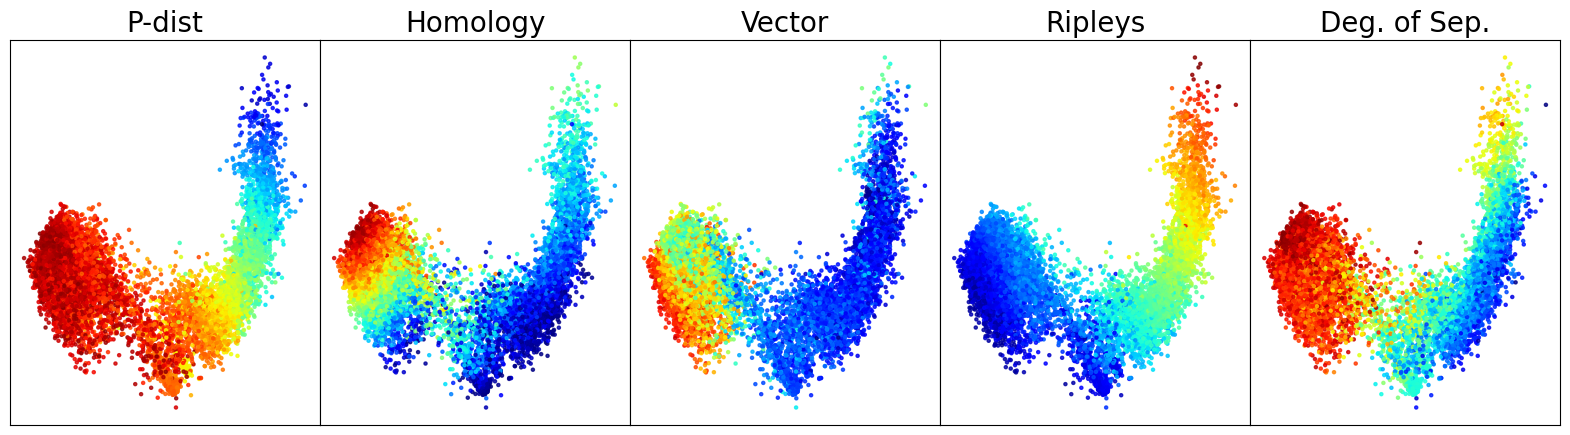

In [15]:
plotting_for_each_scores(embedding_umap)
plotting_for_each_scores(embedding_pca)

Evaluating PCA dimensions: 100%|██████████| 240/240 [07:26<00:00,  1.86s/it]


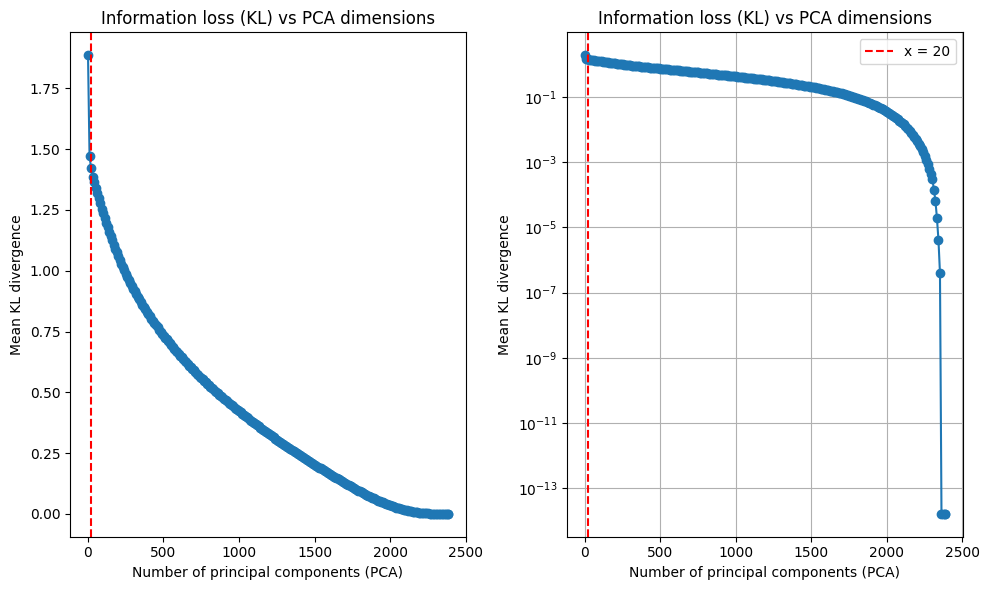

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA
from scipy.special import rel_entr

def kl_divergence(P, Q, epsilon=1e-9):
    P = np.clip(P, epsilon, None)
    Q = np.clip(Q, epsilon, None)

    P = P / P.sum(axis=-1, keepdims=True)
    Q = Q / Q.sum(axis=-1, keepdims=True)

    divergence = np.sum(P * np.log(P / Q), axis=-1)
    return divergence

def evaluatePCAdimensions(file, dims=None, epsilon=1e-9):
    np.random.seed(42)

    df = pd.read_csv(file, index_col=0)
    X = df.values

    X_norm = X / (np.sum(X, axis=1, keepdims=True) + epsilon)

    n_features = X.shape[1]
    pca = PCA(n_components=n_features, random_state=42)
    X_pca_full = pca.fit_transform(X_norm)

    if dims is None:
        dims = np.arange(1, n_features+1, 10)
        if dims[-1] != n_features:
            dims = np.append(dims, n_features)

    kl_divergences = []

    for dim in tqdm(dims, desc="Evaluating PCA dimensions"):
        X_partial = X_pca_full[:, :dim]
        components_partial = pca.components_[:dim, :]
        X_reconstructed = np.dot(X_partial, components_partial) + pca.mean_

        kl = kl_divergence(X_norm, X_reconstructed)
        kl_mean = np.mean(kl)

        kl_divergences.append(kl_mean)

    return dims, kl_divergences

# Usage
dims, kl_vals = evaluatePCAdimensions('data/schuman/filtered_TS_Bladder.csv')

# Plot
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(dims, kl_vals, marker='o')
plt.axvline(x=20, color='red', linestyle='--', label='x = 20')  
plt.xlabel('Number of principal components (PCA)')
plt.ylabel('Mean KL divergence')
plt.title('Information loss (KL) vs PCA dimensions')
plt.yscale('linear')

plt.subplot(1,2,2)
plt.plot(dims, kl_vals, marker='o')
plt.xlabel('Number of principal components (PCA)')

plt.axvline(x=20, color='red', linestyle='--', label='x = 20')
plt.ylabel('Mean KL divergence')
plt.title('Information loss (KL) vs PCA dimensions')
plt.yscale('log')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Figure 6A

In [ ]:
"""def load_benchmark_data(pca_dim = 20):
    np.random.seed(42)
    files = []
    for file in glob.glob("data/benchmarkfiles/*.csv"):
        files.append(file)
    df_real = []
    for file in tqdm(files,position=0, leave=True):
        df = pd.read_csv(file, index_col=0)
        npy_array = np.array(df)
        pca = PCA(n_components=pca_dim, random_state=42)
        embedding = pca.fit_transform(npy_array)
        df_real.append(embedding)
    return df_real, files

def load_organ_data(pca_dim = 20):
    np.random.seed(42)
    files = []
    for file in glob.glob("data/scHuman/*.csv"):
        files.append(file)
    df_real = []
    files_used = []
    for file in tqdm(files,position=0, leave=True):
        df = pd.read_csv(file, index_col=0)
        npy_array = np.array(df)
        if len(npy_array) < 100:
            continue
        pca = PCA(n_components=pca_dim, random_state=42)
        embedding = pca.fit_transform(npy_array)
        df_real.append(embedding)
        files_used.append(file)
    return df_real,files_used

def load_cluster_data(pca_dim = 20):
    np.random.seed(42)
    files = []
    for file in glob.glob("data/datacuration/*.csv"):
        files.append(file)
    df_real = []
    for file in tqdm(files,position=0, leave=True):
        df = pd.read_csv(file, index_col=0)
        npy_array = np.array(df)
        pca = PCA(n_components=pca_dim, random_state=42)
        embedding = pca.fit_transform(npy_array)
        df_real.append(embedding)
    return df_real, files

df_benchmark,benchmark_files = load_benchmark_data()
df_organ,organ_files = load_organ_data()
df_cluster,cluster_files = load_cluster_data()

all_dfs = df_benchmark + df_organ + df_cluster
all_files = benchmark_files + organ_files + cluster_files

META_SCORES = []

for df in tqdm(all_dfs, position=0, leave=True):
    scores = util.scoring(df)
    META_SCORES.append(scores)
npy_real = np.stack(META_SCORES)
np.save('data/real_data_scores.npy',npy_real)"""

'def load_benchmark_data(pca_dim = 20):\n    np.random.seed(42)\n    files = []\n    for file in glob.glob("data/benchmarkfiles/*.csv"):\n        files.append(file)\n    df_real = []\n    for file in tqdm(files,position=0, leave=True):\n        df = pd.read_csv(file, index_col=0)\n        npy_array = np.array(df)\n        pca = PCA(n_components=pca_dim, random_state=42)\n        embedding = pca.fit_transform(npy_array)\n        df_real.append(embedding)\n    return df_real, files\n\ndef load_organ_data(pca_dim = 20):\n    np.random.seed(42)\n    files = []\n    for file in glob.glob("data/scHuman/*.csv"):\n        files.append(file)\n    df_real = []\n    files_used = []\n    for file in tqdm(files,position=0, leave=True):\n        df = pd.read_csv(file, index_col=0)\n        npy_array = np.array(df)\n        if len(npy_array) < 100:\n            continue\n        pca = PCA(n_components=pca_dim, random_state=42)\n        embedding = pca.fit_transform(npy_array)\n        df_real.append(

In [34]:
def plot_real_data_projection_on_umap(scores_real_path,scaler,reducer,embedding_simulated,simulated_coloring):
    npy_real = np.load(scores_real_path)

    real_embs = []
    for i in range(len(npy_real)):
        
        tmp_scaled = scaler.transform(npy_real[i,:].reshape(1, -1))
        tmp_emb = reducer.transform(tmp_scaled.reshape(1, -1))
        real_embs.append(tmp_emb)

    np_real_emb = np.array(real_embs).reshape((len(real_embs), 2))


    plt.figure(figsize=(8,8))
    plt.scatter(embedding_simulated[:,0],embedding_simulated[:,1], c = simulated_coloring, alpha = 1)
    plt.scatter(np_real_emb[:,0],np_real_emb[:,1], c = 'r', s = 100,  marker="^")
    plt.legend()
    plt.axis('off')
    plt.title('Projection of real data in simulated UMAP space', fontsize=14)
    plt.show()

    return np_real_emb

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


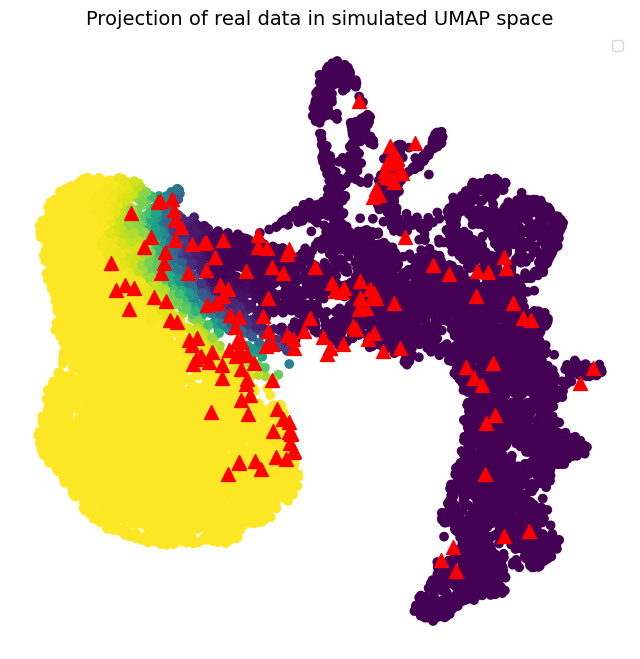

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


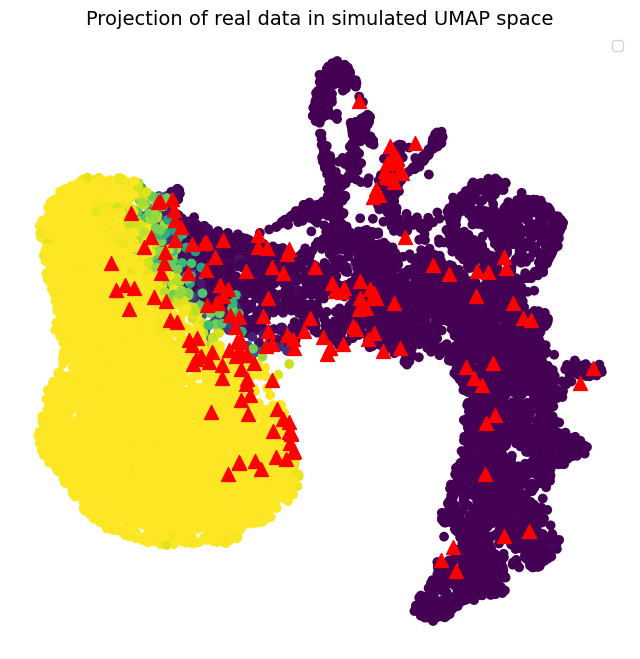

In [ ]:
np_real_emb_KNN = plot_real_data_projection_on_umap(
    scores_real_path='data/real_data_scores.npy',
    scaler=scaler_umap,
    reducer=tmp_reducer_umap,
    embedding_simulated=embedding_umap,
    simulated_coloring=probs_KNN
)
np_real_emb_RF = plot_real_data_projection_on_umap(
    scores_real_path='data/real_data_scores.npy',
    scaler=scaler_umap,
    reducer=tmp_reducer_umap,
    embedding_simulated=embedding_umap,
    simulated_coloring=probs_rf
)

## Fig 6B

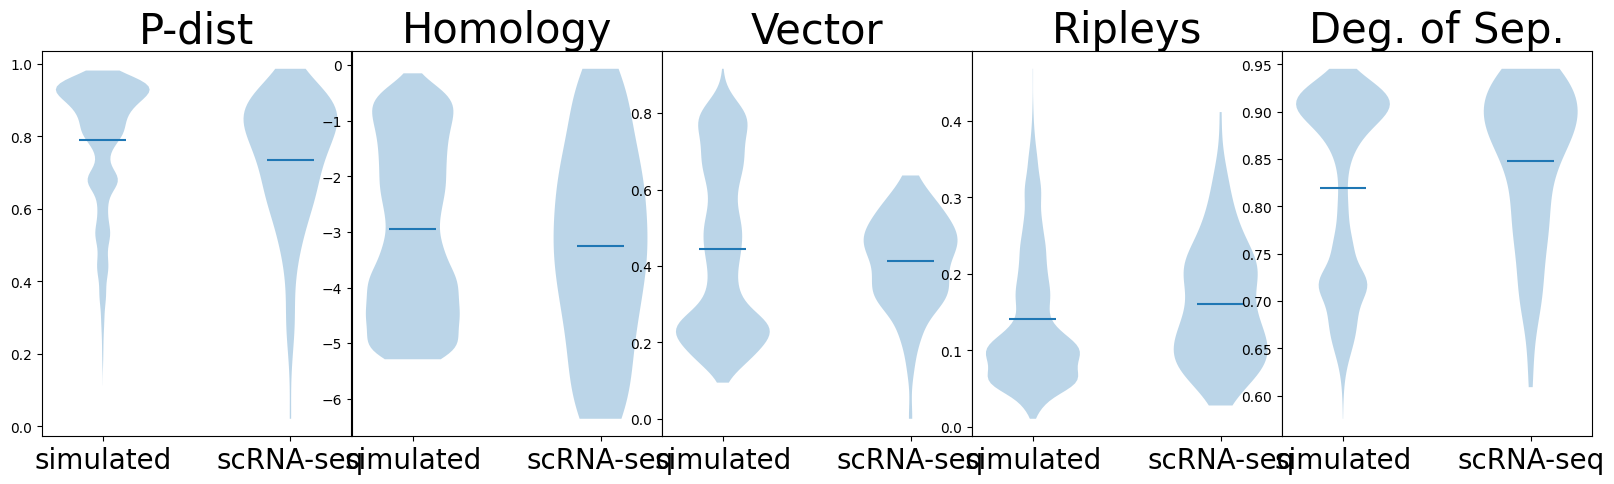

In [25]:
all_sims = np.vstack([np.array(clstr),
                    np.array(clstr_r1),
                    np.array(traj_r1),
                    np.array(traj)])
fig, axs = plt.subplots(1,5, figsize=(20, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
for i in range(5):
    feat = i
    axs[i].violinplot([all_sims[:,feat],npy_real[:,feat]],
                  showmeans = True, showextrema=False)
    axs[i].set_xticks([1, 2], ['simulated','scRNA-seq'], fontsize=20)
    axs[i].set_title(feature_names[i],fontsize=30)
    

In [32]:
## table generation 
data_type = pd.read_csv('data/data_type.csv')
names = []
gold_silver = []
for name in data_type['id']:
    tmp = name.split('/')[-1]
    gold_silver.append(name.split('/')[1])
    names.append(tmp)
data_type['id'] = names

traj_type = []
for name in benchmark_files:
    a = name.split('benchmarkfiles\\')[1].split('.rds')[0]
    tt = data_type[data_type['id'] == a]['trajectory_type']
    label = np.array(tt)[0]
    traj_type.append(label)

for name in organ_files:
    traj_type.append('organ')
    
for name in cluster_files:
    traj_type.append('cluster')

COUNTS = []
for tt in np.unique(np.array(traj_type)):


    query = np.array([np_real_emb[np.array(traj_type) == tt,0],np_real_emb[np.array(traj_type) == tt,1]]).T
    prediction = neigh.predict(query)
    count_cluster=len(np.where(prediction==0)[0])
    count_traj=len(np.where(prediction==1)[0])

    COUNTS.append([count_cluster,count_traj])
fig4_c = pd.DataFrame(COUNTS,columns=['predicted clusters','predicted trajectory'],index = np.unique(np.array(traj_type)))
fig4_c

d:\Anaconda3\envs\scVenv\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
d:\Anaconda3\envs\scVenv\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

predicted clusters  predicted trajectory
acyclic_graph                        1                     0
bifurcation                          7                     6
cluster                             19                    13
convergence                          1                     0
cycle                                1                     1
disconnected_graph                  23                     2
linear                              17                    22
multifurcation                       6                     3
organ                               20                     8
tree                                17                     2

In [33]:
fig4_c.sum()

predicted clusters      112
predicted trajectory     57
dtype: int64

## FIGURE 5

In [41]:
def louvain_labels(df):
    A = kneighbors_graph(np.array(df), 10, mode='connectivity', include_self=True)
    louvain = Louvain()
    labels = louvain.fit_transform(A)
    return labels

LABELS = []
for df in all_dfs:
    labels = louvain_labels(df)
    LABELS.append(labels)

subcluster_scores = []
files_origin = []
ct = 0
for df, labels in zip(all_dfs,LABELS):
    for unq_label in np.unique(labels):
        try:
            idx = np.where(labels == unq_label)[0]
            if len(idx) < 20:
                continue
            tp_df = df[idx,:]
            score = util.scoring(tp_df)
            subcluster_scores.append(score)
            files_origin.append(all_files[ct])
        except:
            continue
    ct += 1

npy_subcluster_scores = np.array(subcluster_scores)

tmp_sub_df = pd.DataFrame(npy_subcluster_scores)
tmp_sub_df.index = files_origin
tmp_sub_df.columns = feature_names
tmp_sub_df.to_csv('data/subcluster_scores.csv')

data/benchmarkfiles\aging-hsc-old_kowalczyk.rds.csv
data/benchmarkfiles\aging-hsc-young_kowalczyk.rds.csv
data/benchmarkfiles\blastocyst-monkey_nakamura.rds.csv
data/benchmarkfiles\bone-marrow-mesenchyme-erythrocyte-differentiation_mca.rds.csv
data/benchmarkfiles\cell-cycle_buettner.rds.csv
data/benchmarkfiles\cell-cycle_leng.rds.csv
data/benchmarkfiles\cellbench-SC1_luyitian.rds.csv
data/benchmarkfiles\cellbench-SC2_luyitian.rds.csv
data/benchmarkfiles\cellbench-SC3_luyitian.rds.csv
data/benchmarkfiles\cellbench-SC4_luyitian.rds.csv
data/benchmarkfiles\cortical-interneuron-differentiation_frazer.rds.csv
data/benchmarkfiles\dentate-gyrus-neurogenesis_hochgerner.rds.csv
data/benchmarkfiles\developing-dendritic-cells_schlitzer.rds.csv
data/benchmarkfiles\distal-lung-epithelium_treutlein.rds.csv
data/benchmarkfiles\embronic-mesenchyme-neuron-differentiation_mca.rds.csv
data/benchmarkfiles\embryonic-mesenchyme-stromal-cell-cxcl14-cxcl12-axis_mca.rds.csv
data/benchmarkfiles\epiblast-monkey_

In [42]:
subcluster_scores = pd.read_csv('data/subcluster_scores.csv',index_col = 0)
npy_subcluster_scores = subcluster_scores.values
sub_emb = []
for i in tqdm(range(len(npy_subcluster_scores))):
    tmp_real = scaler.transform(npy_subcluster_scores[i,:].reshape(1, -1))
    d2_real_embedding = tmp_reducer.transform(tmp_real.reshape(1, -1))
    sub_emb.append(d2_real_embedding)

np_sub_emb = np.array(sub_emb)
np_sub_emb = np_sub_emb.reshape((len(sub_emb),2))
#np.save('data/sub_cluster_embedding.npy',np_sub_emb)


100%|██████████| 2176/2176 [23:35<00:00,  1.54it/s]


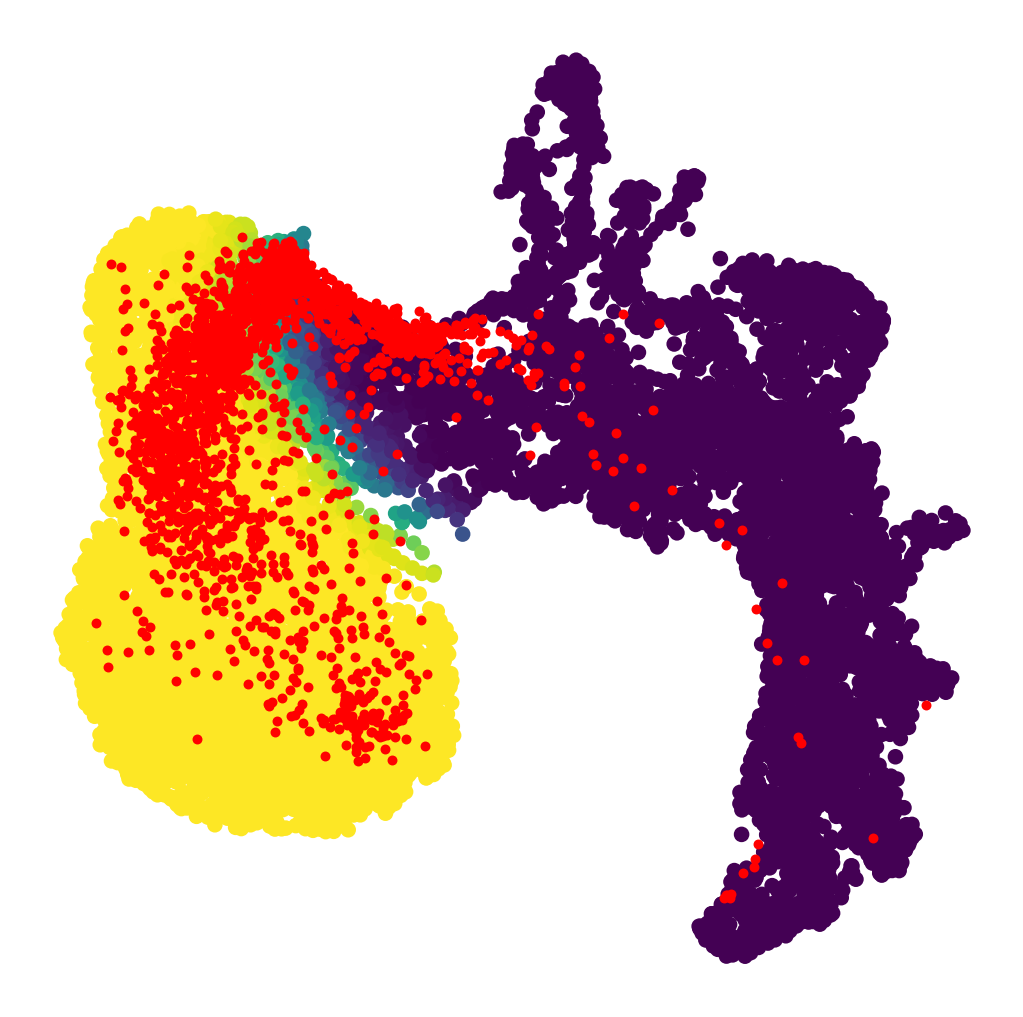

In [43]:
#np_sub_emb = np.load('data/sub_cluster_embedding.npy')
plt.figure(figsize=(8,8))
plt.scatter(embedding[:,0],embedding[:,1], c = p, alpha = 1)
plt.scatter(np_sub_emb[:,0],np_sub_emb[:,1], c = 'r', s = 12)
plt.axis('off')
plt.show()

100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


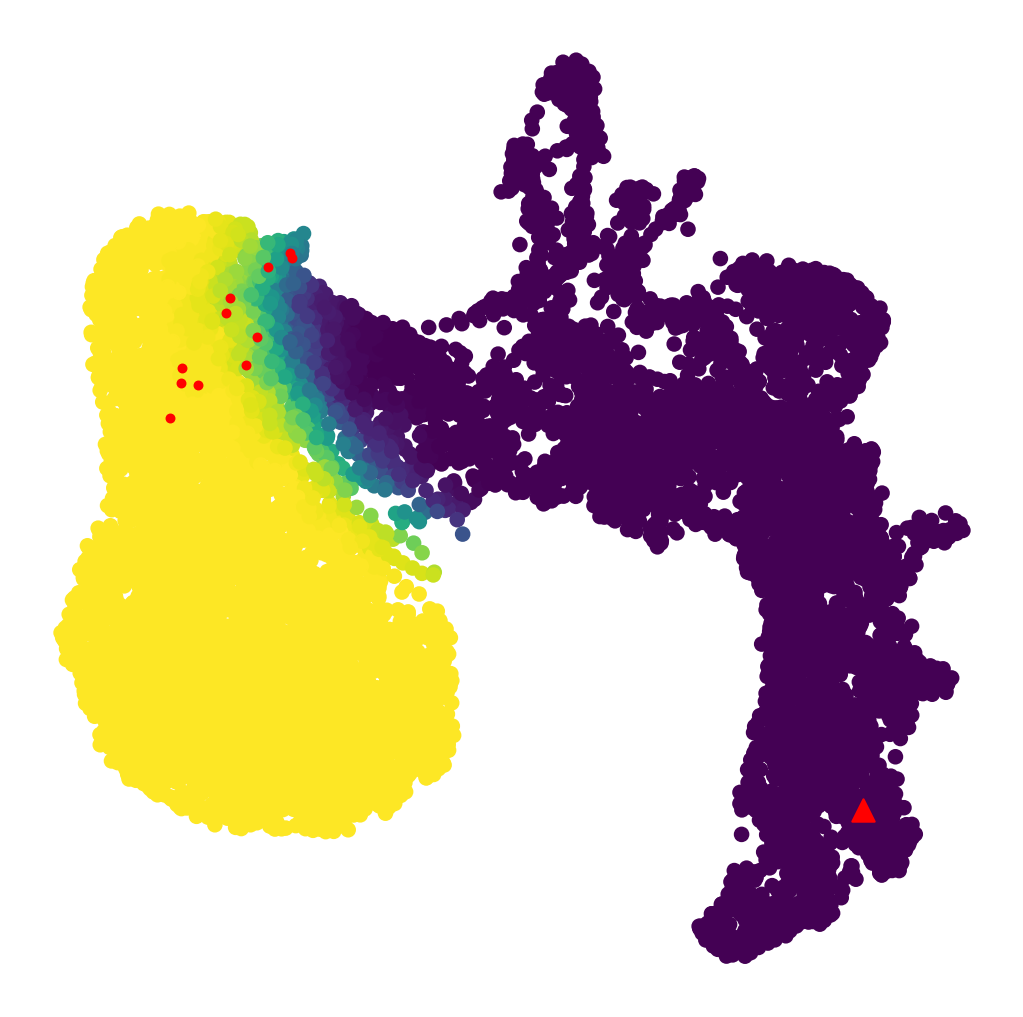

100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


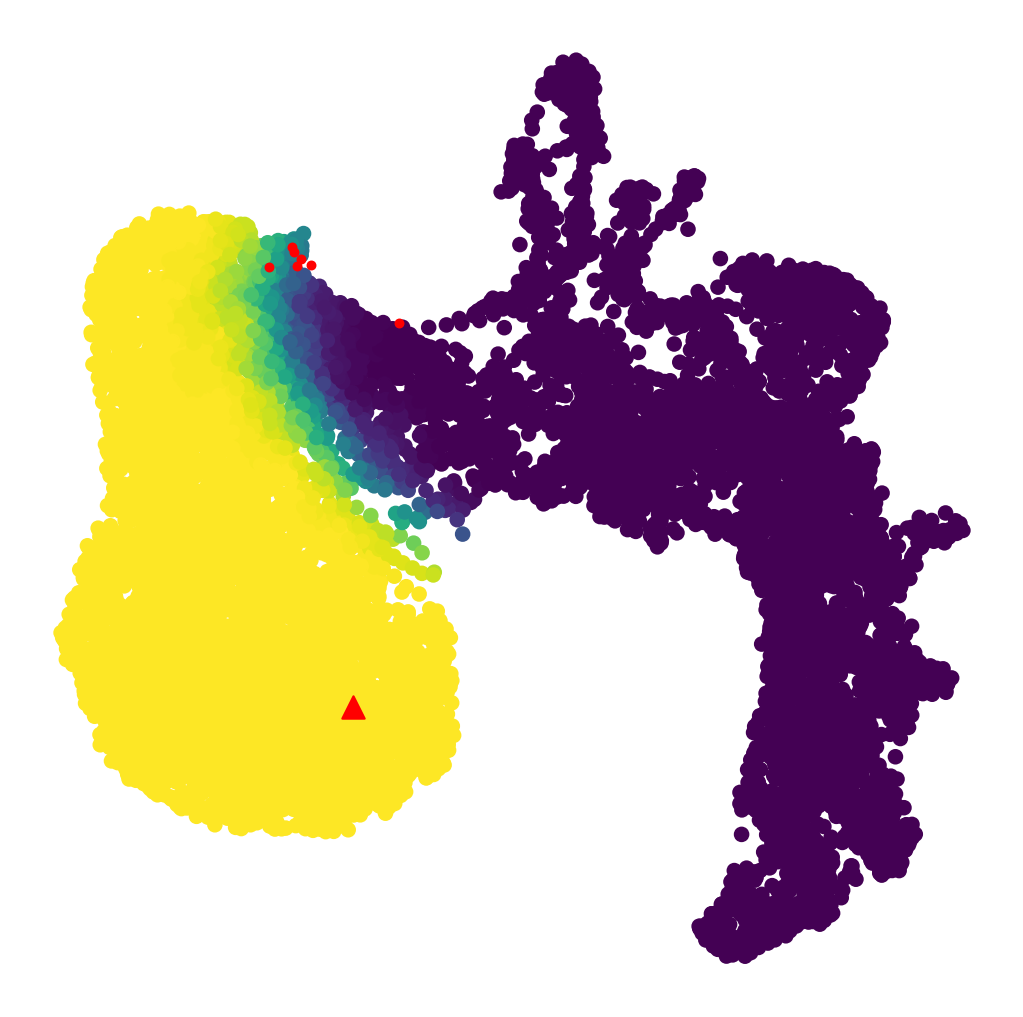

In [71]:
subnames = list(subcluster_scores.index)

nm = 'data/benchmarkfiles\mouse-cell-atlas-combination-1.rds.csv'
example_scores1 = subcluster_scores.loc[nm]
npy_subcluster_example1 = example_scores1.values
sub_emb_exp1 = []
for i in tqdm(range(len(npy_subcluster_example1))):
    tmp_real = scaler.transform(npy_subcluster_example1[i,:].reshape(1, -1))
    d2_real_embedding = tmp_reducer.transform(tmp_real.reshape(1, -1))
    sub_emb_exp1.append(d2_real_embedding)

np_sub_emb_exp1 = np.array(sub_emb_exp1)
np_sub_emb_exp1 = np_sub_emb_exp1.reshape((len(sub_emb_exp1),2))
plt.figure(figsize=(8,8))
plt.scatter(embedding[:,0],embedding[:,1], c = p, alpha = 1)
plt.scatter(np_sub_emb_exp1[:,0],np_sub_emb_exp1[:,1], c = 'r', s = 12)
idx = all_files.index(nm)
plt.scatter(np_real_emb[idx,0],np_real_emb[idx,1], c = 'r', s = 100, marker="^")

plt.axis('off')
plt.show()

nm = 'data/benchmarkfiles\embryonic-mesenchyme-stromal-cell-cxcl14-cxcl12-axis_mca.rds.csv'
example_scores1 = subcluster_scores.loc[nm]
npy_subcluster_example1 = example_scores1.values
sub_emb_exp1 = []
for i in tqdm(range(len(npy_subcluster_example1))):
    tmp_real = scaler.transform(npy_subcluster_example1[i,:].reshape(1, -1))
    d2_real_embedding = tmp_reducer.transform(tmp_real.reshape(1, -1))
    sub_emb_exp1.append(d2_real_embedding)

np_sub_emb_exp1 = np.array(sub_emb_exp1)
np_sub_emb_exp1 = np_sub_emb_exp1.reshape((len(sub_emb_exp1),2))
plt.figure(figsize=(8,8))
plt.scatter(embedding[:,0],embedding[:,1], c = p, alpha = 1)
plt.scatter(np_sub_emb_exp1[:,0],np_sub_emb_exp1[:,1], c = 'r', s = 12)
idx = all_files.index(nm)
plt.scatter(np_real_emb[idx,0],np_real_emb[idx,1], c = 'r', s = 100, marker="^")

plt.axis('off')
plt.show()


## FIGURE 6 and 7

In [74]:
def load_fig6_7_data(pca_dim = 20):
    files = glob.glob("data/fig6_fig7/*.csv")
    df_real = []
    for file in tqdm(files,position=0, leave=True):
        df = pd.read_csv(file, index_col=0)
        npy_array = np.array(df)
        pca = PCA(n_components=pca_dim,random_state=42)
        embedding = pca.fit_transform(npy_array)
        df_real.append(embedding)
    return df_real, files

In [38]:
files = glob.glob('data/fig6_fig7/*.csv')
dfs_fig6_7,names = load_fig6_7_data()
score_fig6_7 = []
for d in dfs_fig6_7:
    score_fig6_7.append(util.scoring(d))

100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


In [39]:
npy_67 = np.array(score_fig6_7)
real_embs_67 = []
for i in range(len(npy_67)):
    tmp_real = scaler.transform(npy_67[i,:].reshape(1, -1))
    d2_real_embedding = tmp_reducer.transform(tmp_real.reshape(1, -1))
    real_embs_67.append(d2_real_embedding)

np_real_emb_67 = np.array(real_embs_67)
np_real_emb_67 = np_real_emb_67.reshape((len(real_embs_67),2))

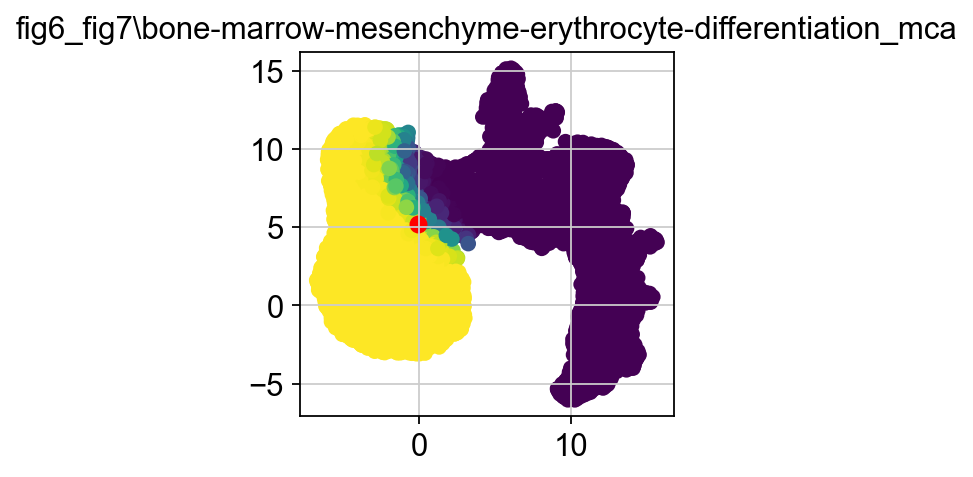

<Figure size 640x640 with 0 Axes>

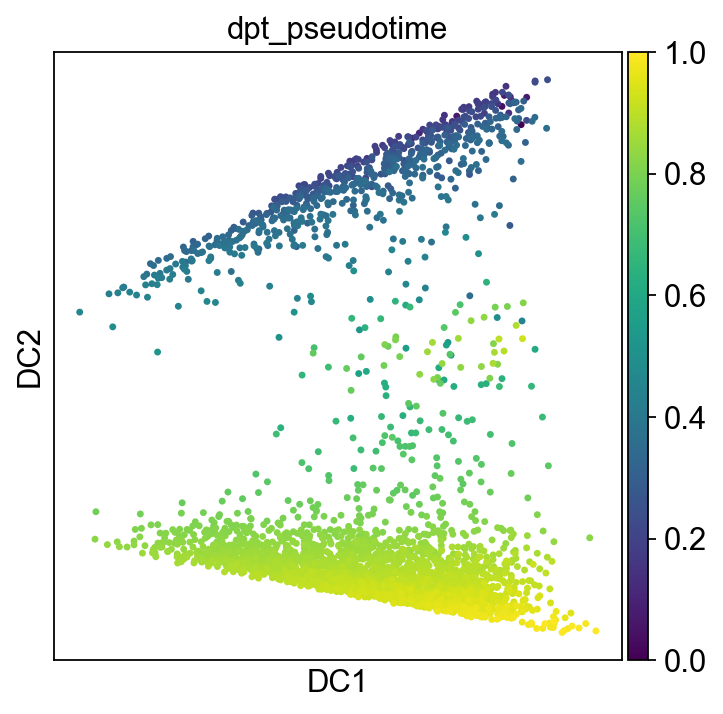

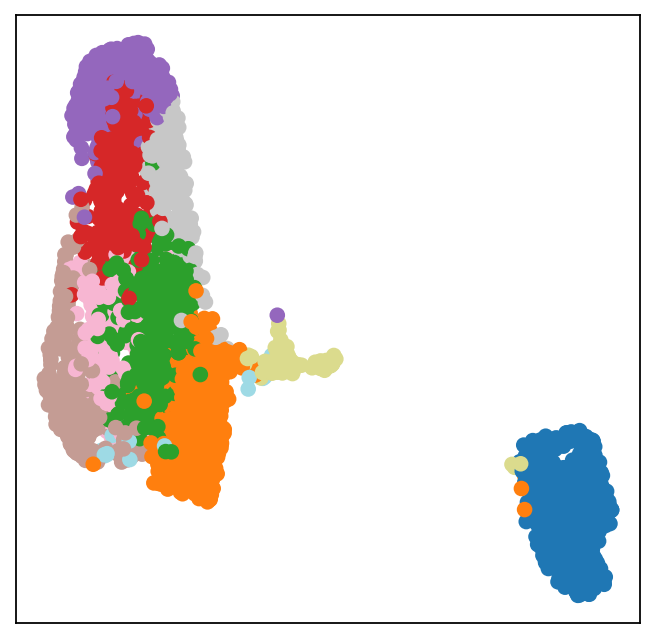

--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=


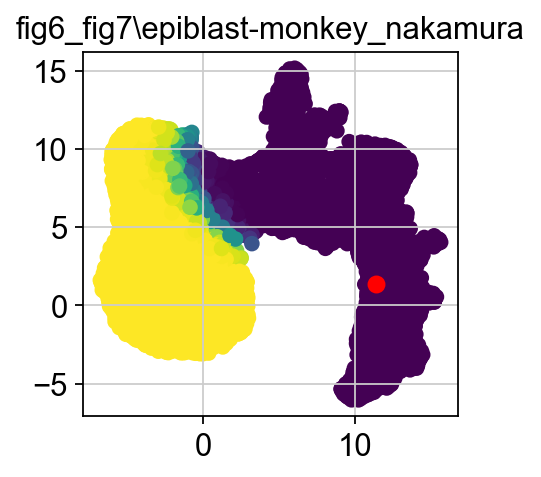

<Figure size 640x640 with 0 Axes>

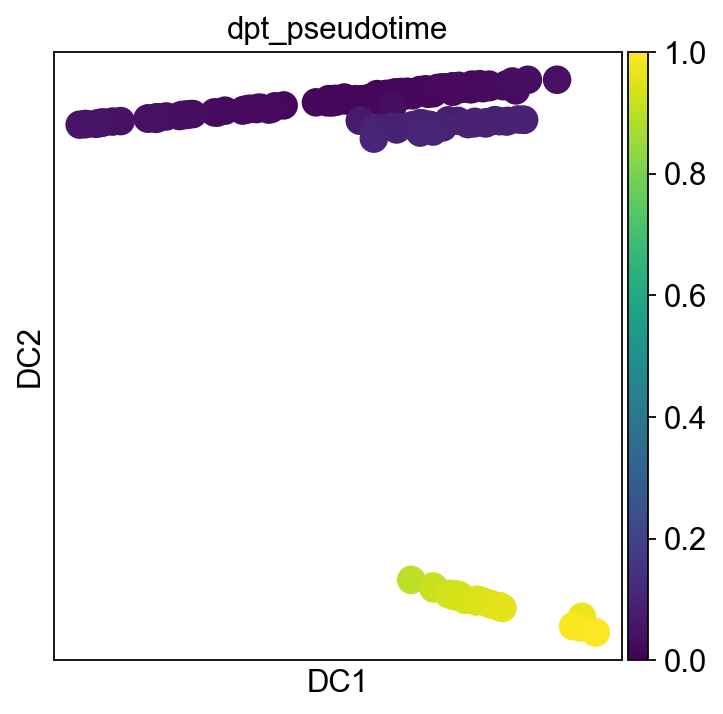

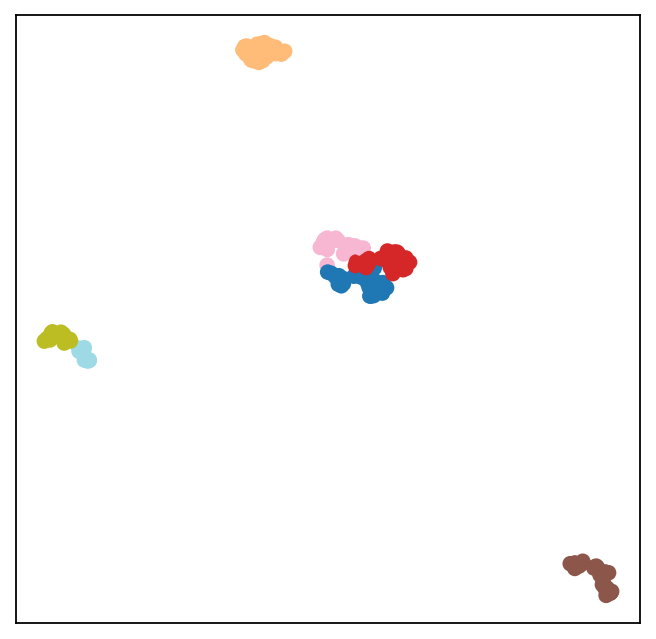

--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=


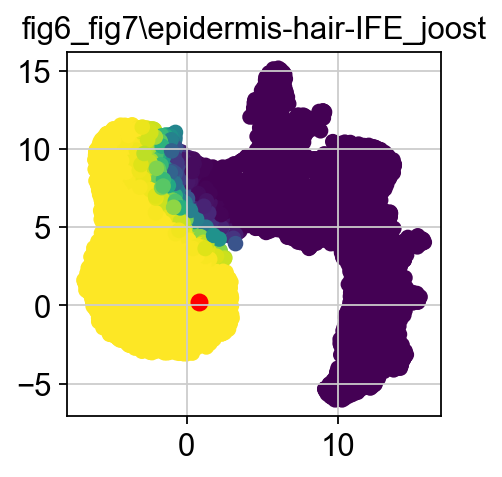

<Figure size 640x640 with 0 Axes>

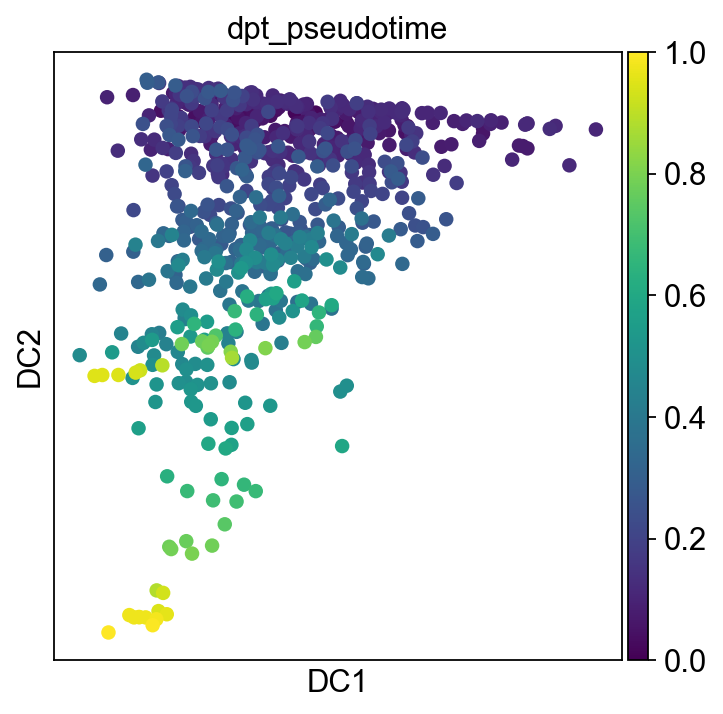

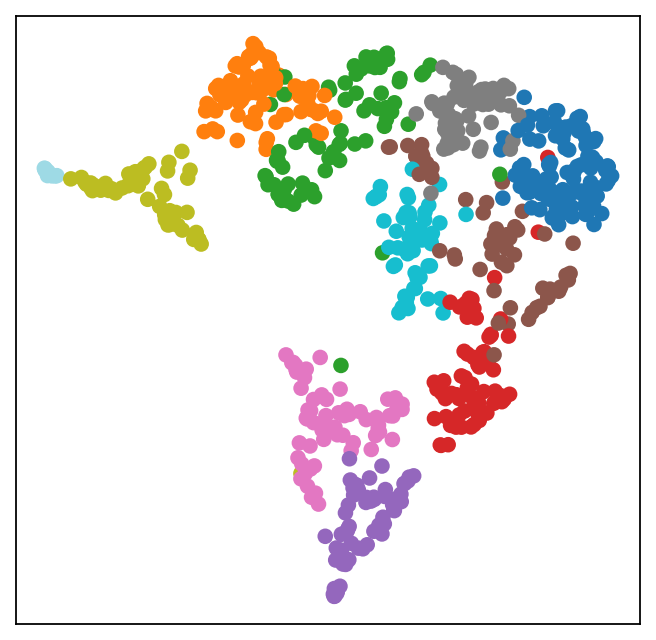

--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=


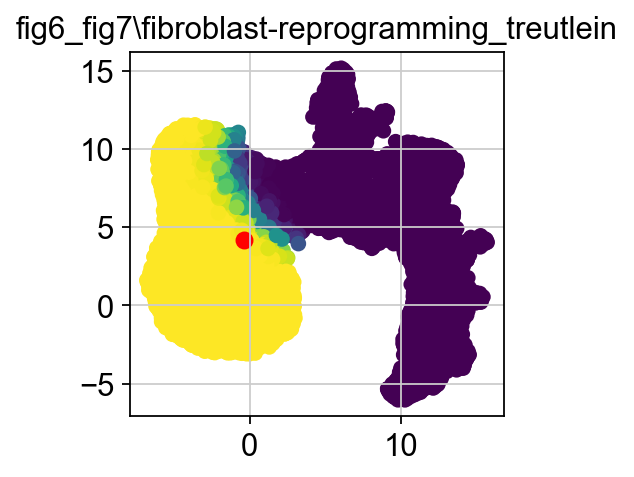

<Figure size 640x640 with 0 Axes>

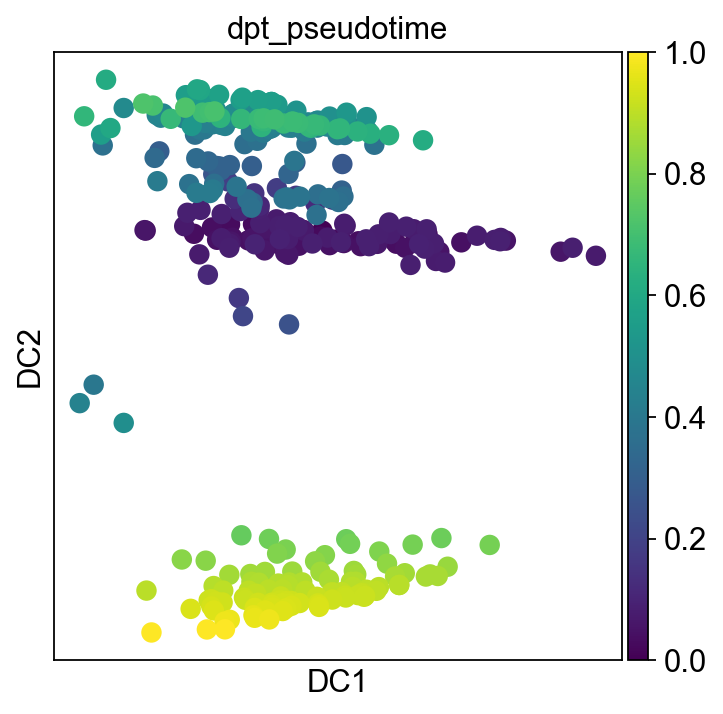

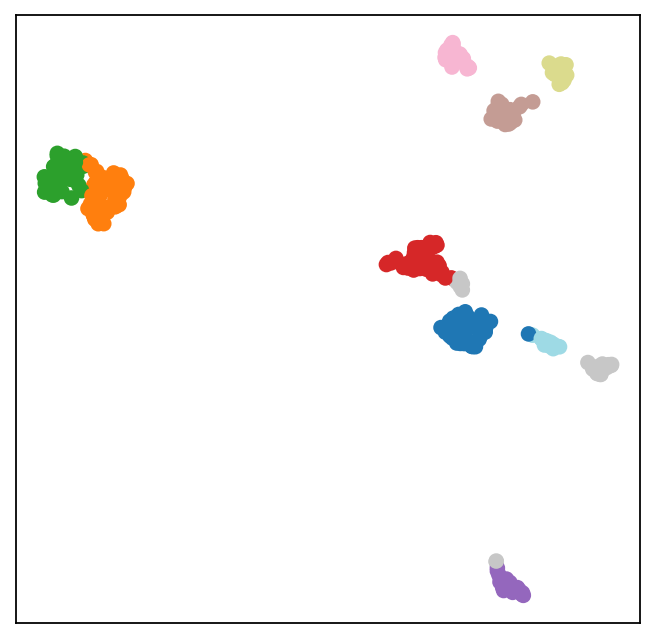

--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=


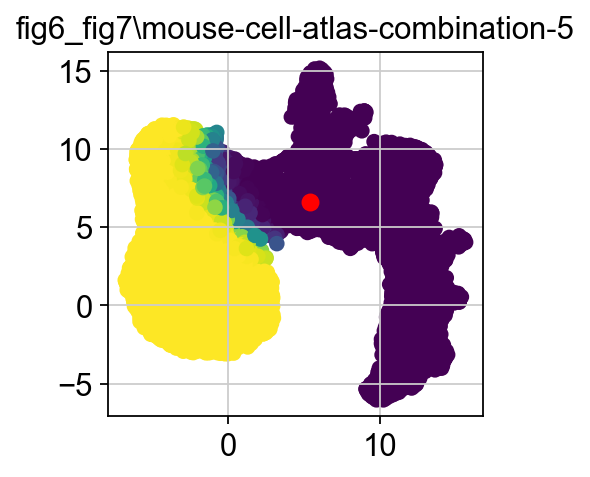

<Figure size 640x640 with 0 Axes>

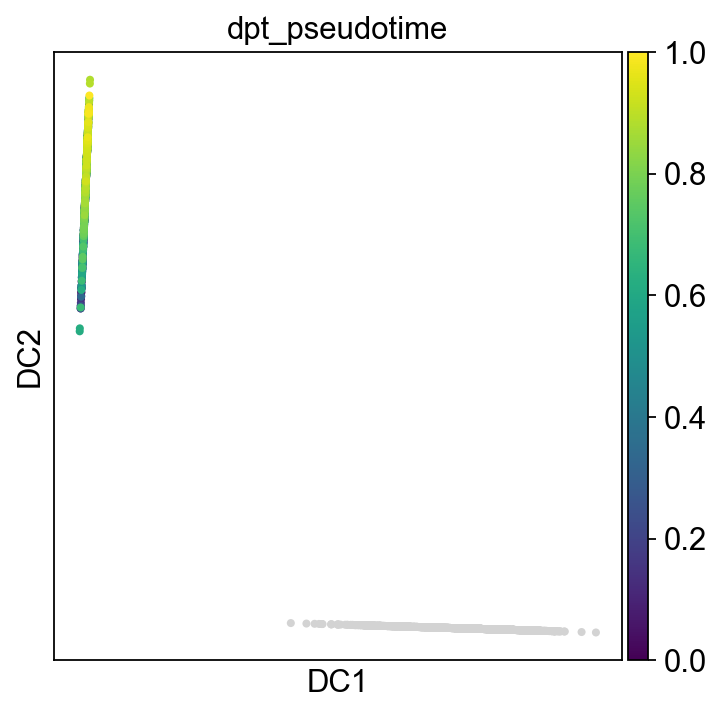

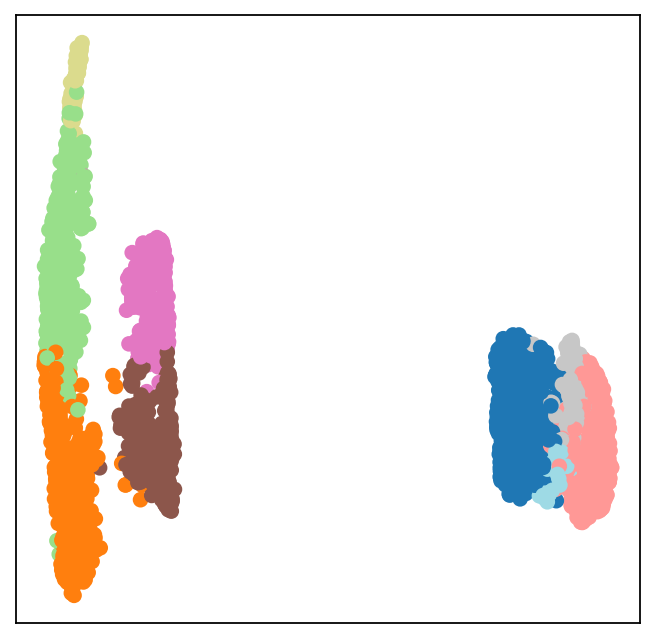

--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=


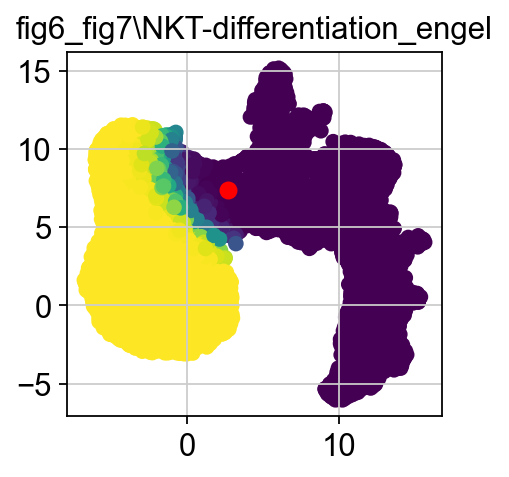

<Figure size 640x640 with 0 Axes>

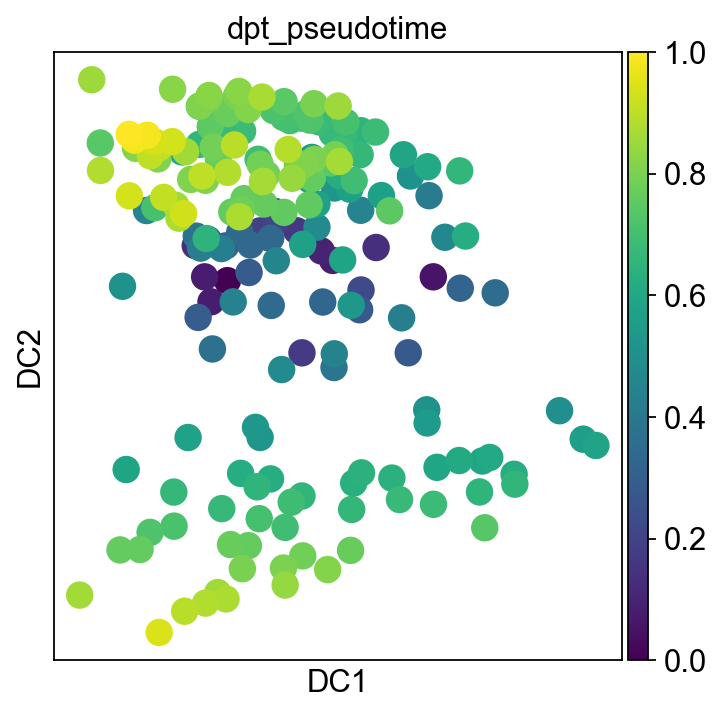

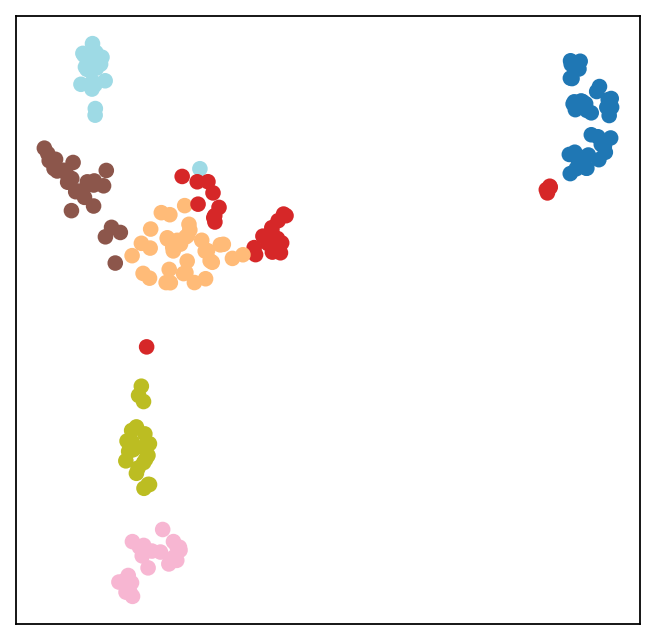

--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=


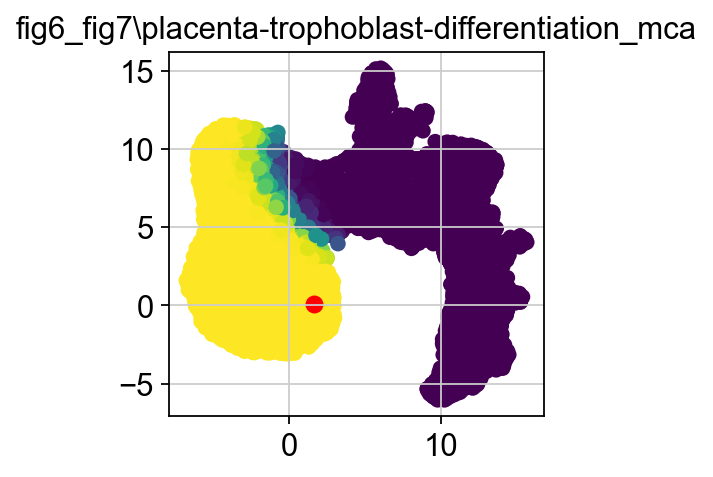

<Figure size 640x640 with 0 Axes>

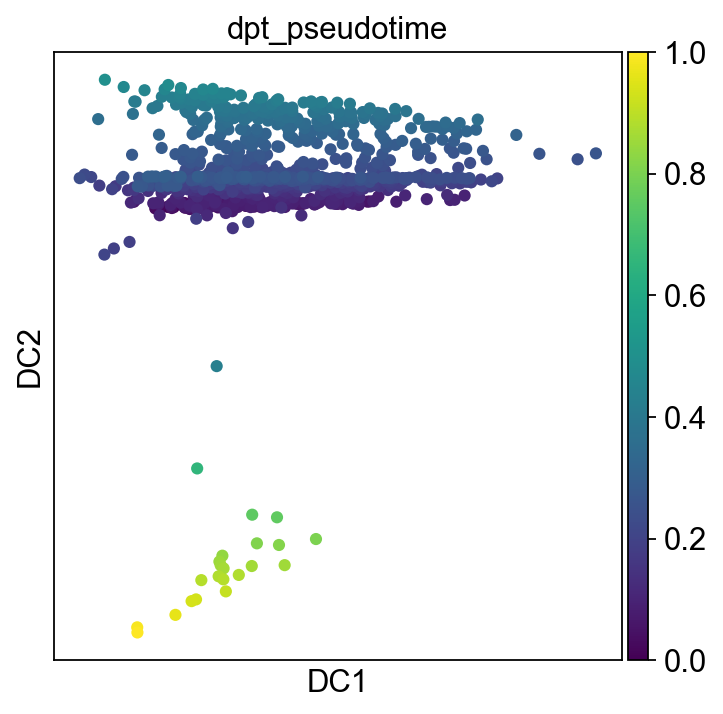

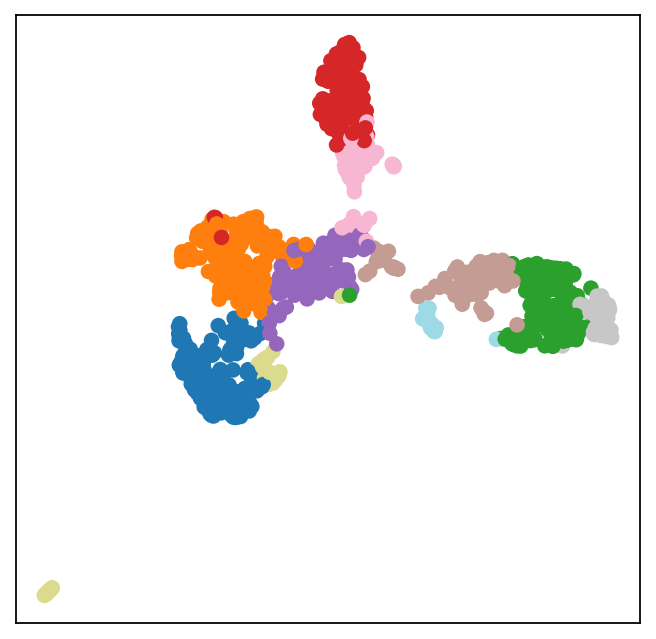

--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=


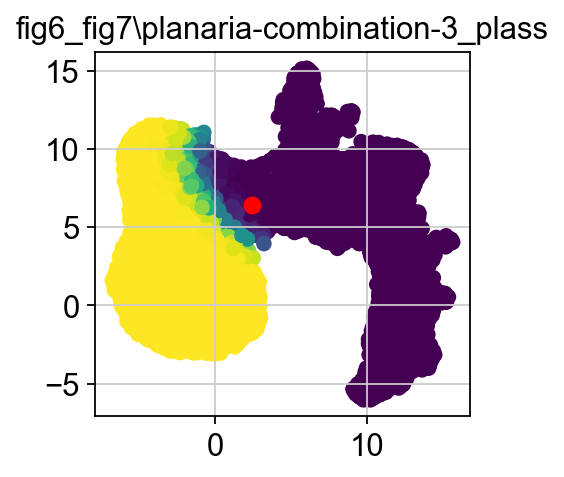

<Figure size 640x640 with 0 Axes>

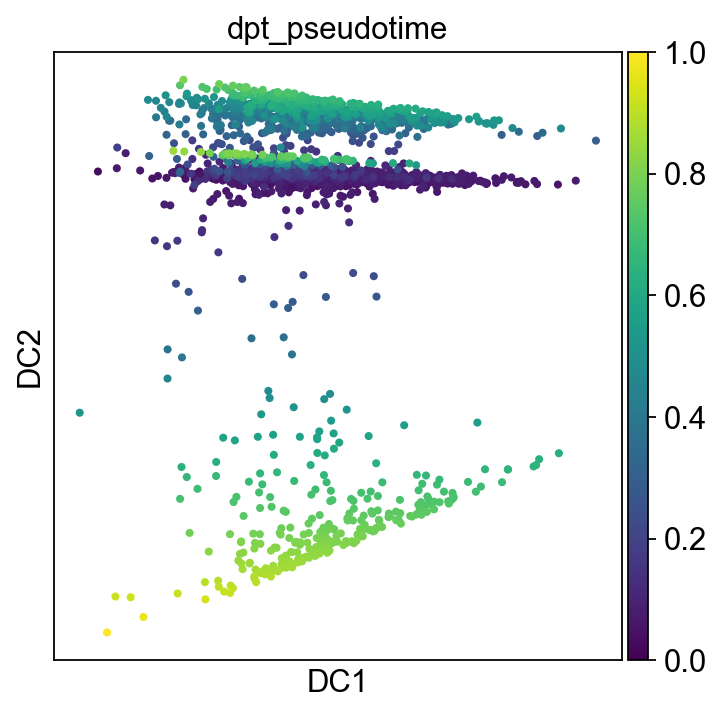

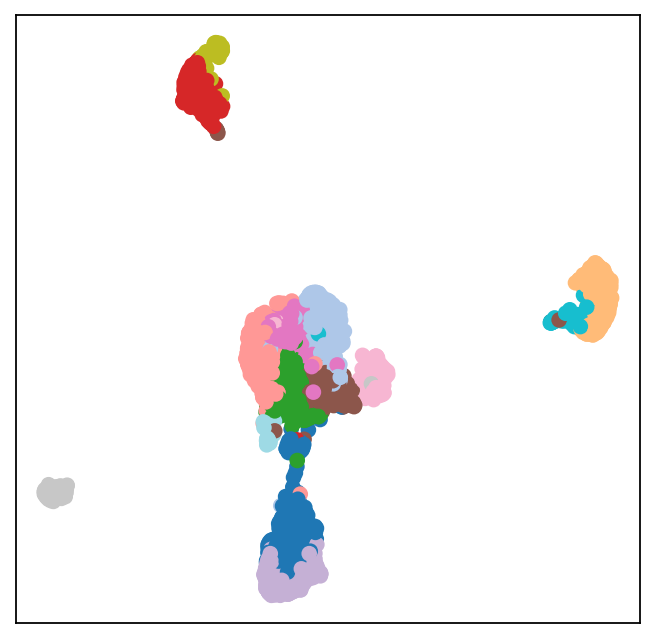

--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=


In [86]:
#
for i in range(len(files)):
        plt.figure(figsize=(3,3))
        plt.scatter(embedding[:,0],embedding[:,1], c = p, alpha = 1)
        plt.scatter(np_real_emb_67[i,0],np_real_emb_67[i,1], c = 'r', s = 50)
        plt.title(names[i].split('/')[-1].split('.rds')[0])
        plt.show()

        df = pd.read_csv(files[i], index_col=0)
        df = preprocessing(np.array(df))
        data = np.array(df)
        data = AnnData(data)
        data.uns['iroot'] = 0 
        plt.figure(figsize=(8,8))
        sp.set_figure_params(dpi=80, dpi_save=150, figsize=(5,5))
        sp.tl.pca(data, svd_solver='arpack')
        sp.pp.neighbors(data)
        sp.tl.diffmap(data)
        sp.tl.dpt(data)
        sp.pl.diffmap(data,color=['dpt_pseudotime'])

        pca = PCA(n_components=20)
        embedding_pca = pca.fit_transform(df)
        A = kneighbors_graph(embedding_pca, 10, mode='connectivity', include_self=True)
        louvain = Louvain()
        labels = louvain.fit_transform(A)
        Umap = umap.UMAP()
        embedding_umap = Umap.fit_transform(embedding_pca)
        fig = plt.figure(figsize=(5,5))
        plt.scatter(embedding_umap[:,0],embedding_umap[:,1],c=labels, alpha=1, cmap='tab20')
        plt.xticks([])
        plt.yticks([])
        plt.show()
        print('--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=')